<a href="https://colab.research.google.com/github/OJB-Quantum/MuMax3-How-To/blob/main/Python%20Code_MuMax3%20Data%20Plots/SOT_Effect_Simulation_with_MuMax3_in_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Check GPU + driver
!nvidia-smi --query-gpu="name,driver_version,compute_cap" --format=csv

name, driver_version, compute_cap
NVIDIA L4, 550.54.15, 8.9


In [2]:
#@title Install MuMax³ (MuMax³ 3.10 CUDA 10.1)
# Download the mumax3 binary
!wget -q https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
!tar -xvf mumax3.10_linux_cuda10.1.tar.gz
!rm mumax3.10_linux_cuda10.1.tar.gz
!rm -rf mumax3.10 && mv mumax3.10_linux_cuda10.1 mumax3.10

# Update the PATH environment variable
import os
os.environ["PATH"] += ":/content/mumax3.10"

mumax3.10_linux_cuda10.1/
mumax3.10_linux_cuda10.1/mumax3-server
mumax3.10_linux_cuda10.1/lib/
mumax3.10_linux_cuda10.1/lib/libcurand.so.10
mumax3.10_linux_cuda10.1/lib/libcufft.so.10
mumax3.10_linux_cuda10.1/mumax3
mumax3.10_linux_cuda10.1/LICENSE
mumax3.10_linux_cuda10.1/mumax3-convert


In [3]:
# @title Step 2 — Write SOT demo (.mx3) with control knobs (PEP 8/257)
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from textwrap import dedent


@dataclass
class Knobs:
    """User controls for a MuMax³ SOT pulse demo.

    Geometry: PMA CoFeB-like nanodot on a heavy metal underlayer (Pt-like).
    SOT is injected as two custom effective fields:
    B_DL ∝ m × σ  and  B_FL ∝ σ.
    """
    # Grid / geometry (nm)
    nx: int = 256
    ny: int = 256
    nz: int = 1
    dx_nm: float = 2.0
    dy_nm: float = 2.0
    t_nm: float = 1.2
    use_dot: bool = True
    dot_diam_nm: float = 160.0  # Circle() expects DIAMETER

    # Material (SI)
    ms_a_per_m: float = 1.10e6
    aex_j_per_m: float = 1.50e-11
    ku1_j_per_m3: float = 6.0e5
    alpha: float = 0.02

    # SOT (spin Hall driven)
    theta_sh: float = 0.10        # Pt-like spin Hall angle
    xi_fl_over_dl: float = 0.60   # H_FL / H_DL ratio

    # Spin polarization σ (unit vector) for +x current, +z normal → σ ≈ +y
    p_x: float = 0.0
    p_y: float = 1.0
    p_z: float = 0.0

    # Drive: SOT pulse, then relax
    jc_on_a_per_m2: float = 2.0e11
    pulse_ns: float = 1.0
    relax_ns: float = 1.0

    # Output cadence
    table_dt_ps: float = 5.0
    snap_dt_ps: float = 50.0

    # Temperature (0 K deterministic; set > 0 for thermal noise)
    temp_k: float = 0.0

    # Files
    script_path: Path = Path("/content/sot_demo.mx3")
    out_dir: Path = Path("/content/sot_out")


def write_mx3(k: Knobs) -> Path:
    """Write a MuMax³ input file that applies a SOT pulse via custom fields."""
    csx = k.dx_nm * 1e-9
    csy = k.dy_nm * 1e-9
    csz = k.t_nm * 1e-9
    diam = k.dot_diam_nm * 1e-9   # Circle() takes diameter (m)
    t_ps = k.table_dt_ps * 1e-12
    s_ps = k.snap_dt_ps * 1e-12
    run1 = k.pulse_ns * 1e-9
    run2 = k.relax_ns * 1e-9

    geom = f"SetGeom(Circle({diam}))" if k.use_dot else "// full rectangle"

    # NOTE: Use ConstVector(...) for p so Cross(m, p) is a Quantity.
    # See workshop example and API "Custom effective field terms". :contentReference[oaicite:1]{index=1}
    mx3 = f"""
// ============================ GRID & GEOMETRY ===============================
SetGridSize({k.nx}, {k.ny}, {k.nz})
SetCellSize({csx}, {csy}, {csz})
SetPBC(0, 0, 0)
{geom}

// ================================ MATERIAL =================================
Msat  = {k.ms_a_per_m}
Aex   = {k.aex_j_per_m}
Ku1   = {k.ku1_j_per_m3}
AnisU = Vector(0, 0, 1)
alpha = {k.alpha}
{"Temp = %g" % k.temp_k if k.temp_k > 0 else ""}

// Initialize up (PMA) and relax slightly
m = Uniform(0, 0, 1)
Minimize()

// =============================== OUTPUT SCHEDULE ============================
AutoSave(m, {s_ps})
TableAutoSave({t_ps})

// =============================== PRE-PULSE RELAX ============================
Run(0.2e-9)

// =============================== SOT FIELDS (PULSE) ========================
// B_DL = a_J * (m × p),  B_FL = b_J * p
// a_J = (ħ * theta_SH / (2 e Ms t_F)) * Jc,  b_J = xi * a_J

theta_SH := {k.theta_sh}
xiSOT    := {k.xi_fl_over_dl}

e    := 1.602176634e-19
hbar := 1.054571817e-34
tF   := {csz}
Ms   := {k.ms_a_per_m}

p := ConstVector({k.p_x}, {k.p_y}, {k.p_z})   // <-- Quantity, not plain data.Vector
Jc := Const({k.jc_on_a_per_m2})

// Prefactor c [Tesla per (A/m^2)]
c  := Const(hbar * theta_SH / (2*e*Ms*tF))

// a_J and b_J (ScalarFunctions)
aJ := Mul(Jc, c)
bJ := Mul(aJ, Const(xiSOT))

// Custom effective fields promoted into B_eff
B_DL := Mul(aJ, Cross(m, p))   // → torque ∝ m × (σ × m)
B_FL := Mul(bJ, p)             // → torque ∝ m × σ

AddFieldTerm(B_DL)
AddFieldTerm(B_FL)

// Pulse on
Run({run1})

// ============================ REMOVE SOT & RELAX ============================
RemoveCustomFields()
Run({run2})

// Final snapshot
Save(m)
"""
    k.script_path.write_text(dedent(mx3).strip() + "\n", encoding="utf-8")
    return k.script_path


KNOBS = Knobs()
mx3_path = write_mx3(KNOBS)
print(f"Wrote: {mx3_path}")
print(f"Output dir: {KNOBS.out_dir}")


Wrote: /content/sot_demo.mx3
Output dir: /content/sot_out


In [4]:
# @title Step 3 — Run MuMax³ with explicit output directory
from pathlib import Path

Path("/content/sot_out").mkdir(parents=True, exist_ok=True)
!mumax3 -o /content/sot_out -f /content/sot_demo.mx3

# Quick listing for sanity
!ls -lh /content/sot_out | sed -n '1,80p'


//mumax 3.10 [linux_amd64 go1.14(gc) CUDA-10.1]
//GPU info: NVIDIA L4(22692MB), CUDA Driver 12.4, cc=8.9, using cc=75 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: /content/sot_out/
//starting GUI at http://127.0.0.1:35367
SetGridSize(256, 256, 1)
SetCellSize(2e-09, 2e-09, 1.2e-09)
SetPBC(0, 0, 0)
//resizing...
// Initializing geometry 0 %
// Initializing geometry 100 %
SetGeom(Circle(1.6e-07))
Msat = 1100000.0
Aex = 1.5e-11
Ku1 = 600000.0
AnisU = Vector(0, 0, 1)
alpha = 0.02
m = Uniform(0, 0, 1)
Minimize()
//Did not use cached kernel: open /tmp/mumax3kernel_[256 256 1]_[0 0 0]_[2e-09 2e-09 1.2e-

           t        mx       my       mz
2.160068e-09 -0.205992 0.358328 0.729051
2.165057e-09 -0.151122 0.381492 0.731027
2.170048e-09 -0.092828 0.396961 0.732829
2.175047e-09 -0.032198 0.404499 0.734386
2.180054e-09  0.029510 0.403977 0.735603
2.185056e-09  0.090818 0.395411 0.736390
2.190050e-09  0.150338 0.378966 0.736706
2.195039e-09  0.206836 0.354890 0.736579


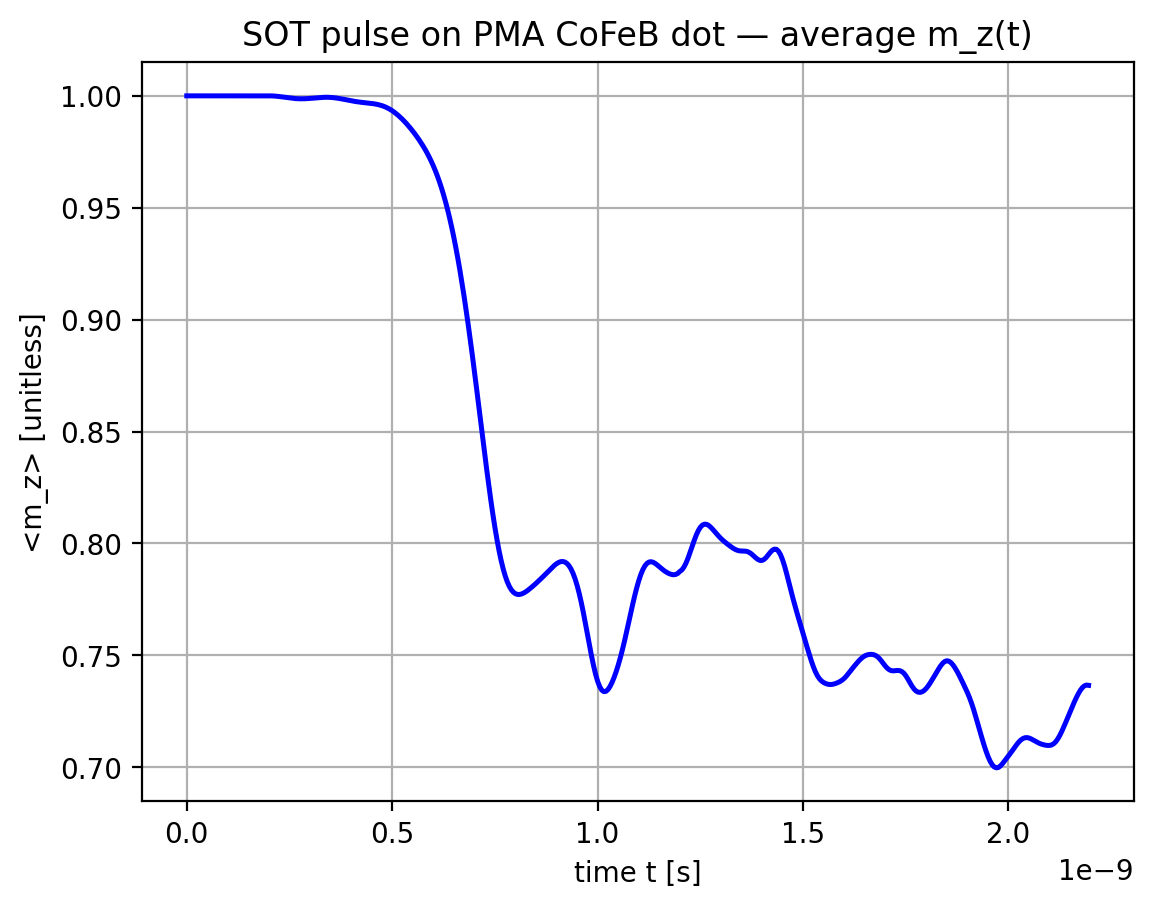

In [5]:
# @title Step 4 — Read table and plot <m_z>(t) at 200 dpi (PEP 8/257)
from __future__ import annotations

from pathlib import Path
from typing import List
import pandas as pd
import matplotlib.pyplot as plt


def load_mumax_table(path: Path) -> pd.DataFrame:
    """Return DataFrame from a MuMax³ table file, renaming first 4 columns."""
    if not path.exists():
        raise FileNotFoundError(f"Missing MuMax³ table: {path}")
    df = pd.read_csv(path, sep=r"\s+", engine="python", comment="#", header=None)
    ncols = df.shape[1]
    names: List[str] = ["t", "mx", "my", "mz"] + [f"col{i}" for i in range(4, ncols)]
    df.columns = names[:ncols]
    return df


df = load_mumax_table(Path("/content/sot_out/table.txt"))
print(df.tail(8).to_string(index=False))

plt.rcParams.update({"figure.dpi": 200})
plt.figure()
plt.plot(df["t"], df["mz"], linewidth=1.8, color='blue')
plt.xlabel("time t [s]")
plt.ylabel("<m_z> [unitless]")
plt.title("SOT pulse on PMA CoFeB dot — average m_z(t)")
plt.grid(True)
plt.show()


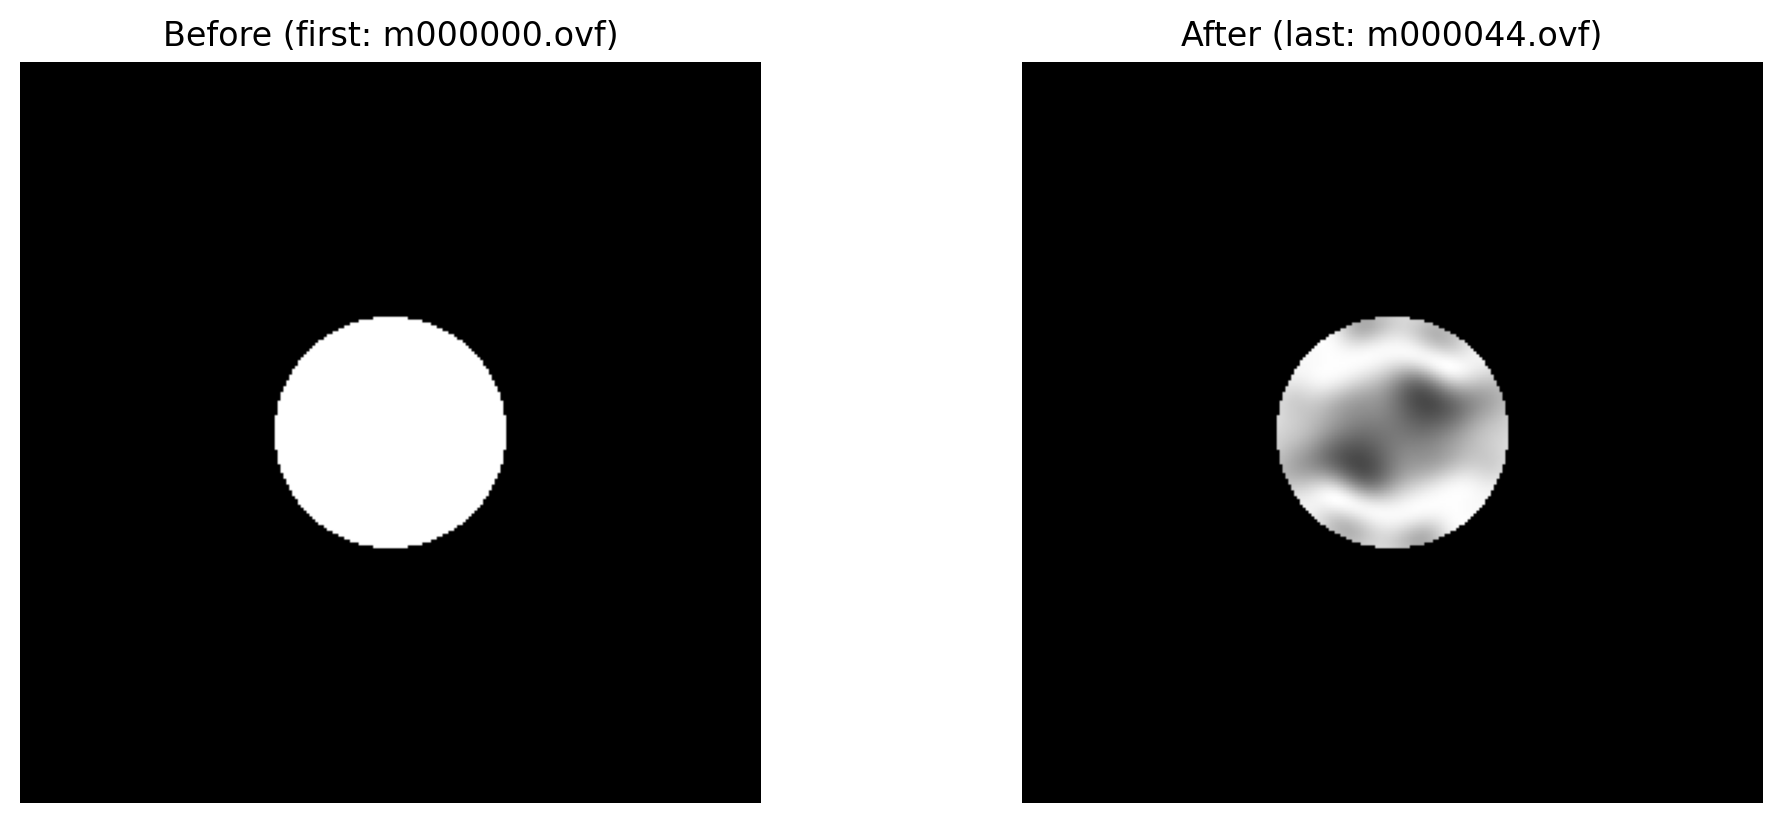

In [6]:
# @title Step 5 — Convert BEFORE & AFTER OVFs → PNG and show side-by-side
from __future__ import annotations

import subprocess
from pathlib import Path
from typing import Tuple, List
import glob

from PIL import Image
import matplotlib.pyplot as plt


OUT_DIR = Path("/content/sot_out")
COMPONENT: str = "z"   # "x", "y", "z" or 0, 1, 2 (per mumax3-convert manual)
ARROWS: int = 0        # set > 0 to overlay arrows; 0 disables arrows


def find_first_last_ovf(pattern: str = "m*.ovf") -> Tuple[Path, Path]:
    """Return paths to the first and last OVF magnetization snapshots."""
    files: List[str] = sorted(glob.glob(str(OUT_DIR / pattern)))
    if not files:
        raise FileNotFoundError(f"No OVF files matching {pattern} found in {OUT_DIR}")
    return Path(files[0]), Path(files[-1])


def convert_ovf_to_png(ovf: Path) -> Path:
    """Convert an OVF file to PNG via mumax3-convert and return the PNG path."""
    cmd = ["mumax3-convert", f"-comp={COMPONENT}", "-png", "-o", str(OUT_DIR), str(ovf)]
    if ARROWS:
        cmd.insert(1, f"-arrows={ARROWS}")
    subprocess.run(cmd, check=True)

    # The tool writes <stem>.png in OUT_DIR (or a very similar name).
    png_candidate = OUT_DIR / f"{ovf.stem}.png"
    if png_candidate.exists():
        return png_candidate

    matches = sorted(OUT_DIR.glob(f"{ovf.stem}*.png"))
    if not matches:
        raise FileNotFoundError(f"PNG not found after conversion for {ovf.name}")
    return matches[-1]


before_ovf, after_ovf = find_first_last_ovf()
before_png = convert_ovf_to_png(before_ovf)
after_png = convert_ovf_to_png(after_ovf)

plt.rcParams.update({"figure.dpi": 200})

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
axes[0].imshow(Image.open(before_png))
axes[0].set_title(f"Before (first: {before_ovf.name})")
axes[0].axis("off")

axes[1].imshow(Image.open(after_png))
axes[1].set_title(f"After (last: {after_ovf.name})")
axes[1].axis("off")

plt.show()